# Prérequis

Ce notebook requiert les modules matplotlib, seaborn, plotly, ainsi que le module imgtools qui regroupe des fonctions nous avons crées pour ce projet.  
Le notebook utilise également le module 'tqdm' (https://github.com/tqdm/tqdm#readme). Si vous ne souhaitez pas le télécharger, laisser la valeur False ci-dessous, sinon la passer à True.

In [1]:
with_tqdm = True

# Initialisation

In [2]:
# Modules usuels
import pandas as pd
import numpy as np
import random
import pickle

# Modules graphiques
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Modules additionnels
import imgtools as imt
if imt.version != 2:
    raise ImportError("Ta version de imgtools n'est pas la bonne !")
if with_tqdm:
    from tqdm import tqdm
else:
    def tqdm(it):
        return it

# Relative paths
PATH_TRAIN = "./images/image_train"
PATH_TEST = "./images/image_test"

# Extraction des données

In [3]:
# Chargement du jeu de données d'entrainement
df = pd.read_csv('trainset.csv')
cols_cat = ['productid', 'imageid', 'target']
df[cols_cat] = df[cols_cat].astype('str')
df = df.set_index('productid')
df.head()

designation  \
productid                                                       
3804725264  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110   Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756    Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884                                La Guerre Des Tuques   

                                                  description     imageid  \
productid                                                                   
3804725264                                                NaN  1263597046   
436067568                                                 NaN  1008141237   
201115110   PILOT STYLE Touch Pen de marque Speedlink est ...   938777978   
50418756                                                  NaN   457047496   
278535884   Luc a des id&eacute;es de grandeur. Il veut or...  1077757786   

           target  
productid          
3804725264      0  
436067568       1  
201115110       2  
50418756        3  
278535884       4

In [11]:
# Chargement de la table de correspondance des labels
lab_enc = pd.read_csv('labels_encoding.csv').astype('str')
lab_enc.transpose()

0          1                        2   \
prdtypecode             10       2280                       50   
target                   0          1                        2   
prdtype      livres_adulte  magazines  accessoires_jeux_videos   

                         3                    4          5   \
prdtypecode            1280                 2705       2522   
target                    3                    4          5   
prdtype      jouets_enfance  livres_et_illustres  papeterie   

                                  6                            7   \
prdtypecode                     2582                         1560   
target                             6                            7   
prdtype      mobilier_jardin_cuisine  mobilier_interieur_litterie   

                       8                      9   ...                    17  \
prdtypecode          1281                   1920  ...                  2060   
target                  8                      9  ...                    17   
prdtype      jeux_societe  accessoires_interieur  ...  decoration_interieur   

                             18                      19              20  \
prdtypecode                  40                      60            1320   
target                       18                      19              20   
prdtype      jeux_videos_import  jeux_et_consoles_retro  petite_enfance   

                         21                        22  \
prdtypecode            1302                      2220   
target                   21                        22   
prdtype      jouets_enfants  pour_animaux_domestiques   

                                     23                24          25  \
prdtypecode                        2905              2585        1940   
target                               23                24          25   
prdtype      jeux_videos_dematerialises  jardin_bricolage  nourriture   

                           26  
prdtypecode              1301  
target                     26  
prdtype      materiel_enfance  

[3 rows x 27 columns]

# Distribution des classes

In [5]:
# Calcul des distributions de classes et des NAs
count_na = lambda x: x.isnull().sum()
func_gby = {'description': count_na, "imageid": 'count'}
cls_descr = df[['target', 'imageid', 'description']].groupby("target").agg(func_gby).reset_index()
cls_descr = cls_descr.rename({"description":"nb_nan_per_class", "imageid":"count_prod_per_class"}, axis=1)
cls_descr['%_nan'] = round((cls_descr["nb_nan_per_class"]/cls_descr['count_prod_per_class'])*100)
cls_descr['%Class'] = round((cls_descr["count_prod_per_class"]/len(df))*100)
cls_descr = cls_descr.set_index('target')

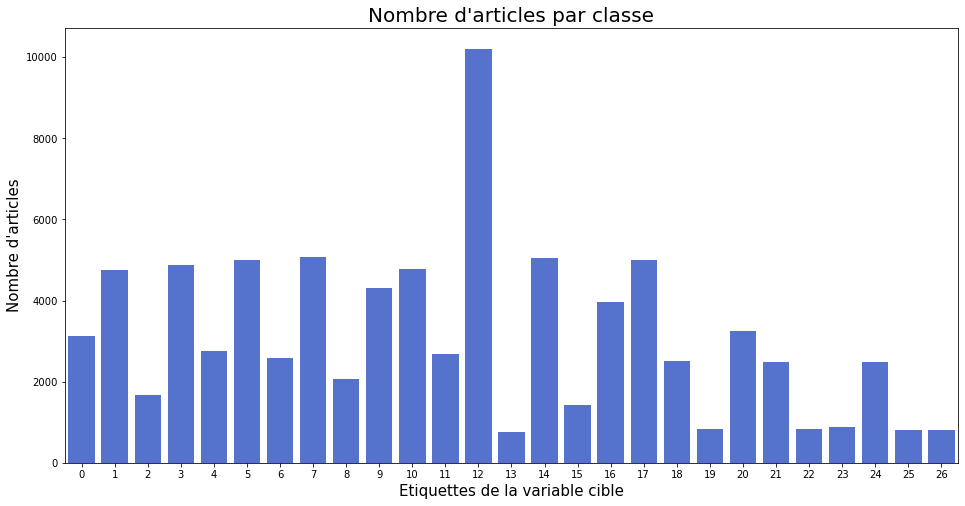

In [6]:
# Affichage de la distribution des classes
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(ax=ax, data=df, x='target', color='royalblue')
plt.title("Nombre d'articles par classe", fontsize=20)
plt.xlabel("Etiquettes de la variable cible", fontsize=15)
plt.ylabel("Nombre d'articles", fontsize=15);

Classes déséquilibrées: la classe la plus majoritaire représente 12% et les minoritaires représentent 1% (ou moins).

#### Quelles stratégies adopter ?

1) Undersampling => cela revient à avoir ~800 lignes par classe (est-ce suffisant ? )  
2) Undersampling + oversampling à ~4000 lignes (on utilise la duplication de données)  
3) Pondération des samples en fonction de leur classe (pénaliser les classes majoritaires)  
4) Changer les seuils de probabilité en fonction de la taille des classes (pénaliser les classes majoritaires)  

# Valeurs manquantes

## Vue globale

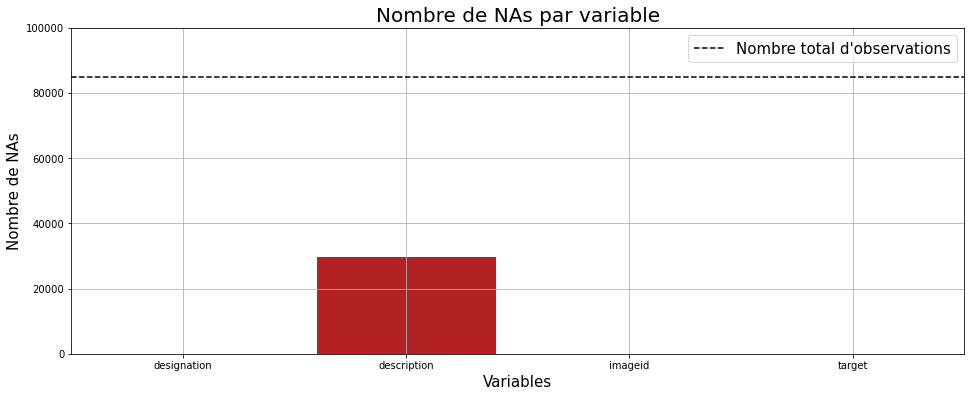

In [7]:
# Nombre de NAs par colonne
plt.figure(figsize=(16, 6))
plt.bar(x=df.columns, height=df.isna().sum(), color='firebrick')
plt.hlines(len(df), -0.5, 3.5, color='k', linestyle='dashed', label="Nombre total d'observations")
plt.axis([-0.5, 3.5, 0, 100000])
plt.title("Nombre de NAs par variable", fontsize=20)
plt.xlabel("Variables", fontsize=15)
plt.ylabel("Nombre de NAs", fontsize=15)
plt.legend(fontsize=15)
plt.grid();

#### Il faut reflechir à une stratégie de traitement des valeurs manquantes

1) Traiter uniquement la colonne "designation"   
2) Remplacer les NAs de la colonne "description" par les valeurs de "designation"   
3) Fusionner la colonne "designation" et colonne "description"

## Répartition des valeurs manquantes selon les classes

In [8]:
# Affichage
fig = go.Figure(data=[
    go.Bar(name='Articles', x=cls_descr.index, y=cls_descr["count_prod_per_class"]),
    go.Bar(name='NAs', x=cls_descr.index, y=cls_descr["nb_nan_per_class"])
])
# Change the bar mode
fig.update_layout(barmode='group', title_text="Valeurs manquantes par classe",
                  xaxis_title="Classes", yaxis_title="Nombre")
fig.show();

Il est clair que certaines classes de produits sont plus touchées que d'autres par les descriptions manquantes. Peut-être que certains produits sont davantage vendus par des amateurs qui ne prennent pas la peine de tout remplir rigoureusement. Souvent l'essentiel des informations se trouve dans le champ 'designation'.

# Affichage de 5 images par classe

100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


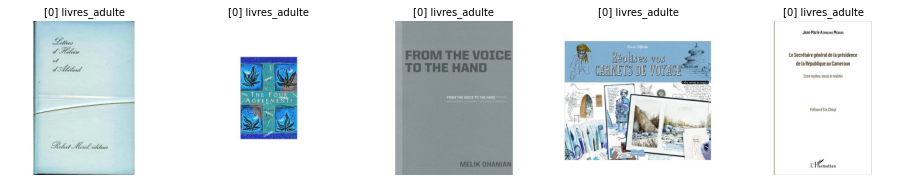

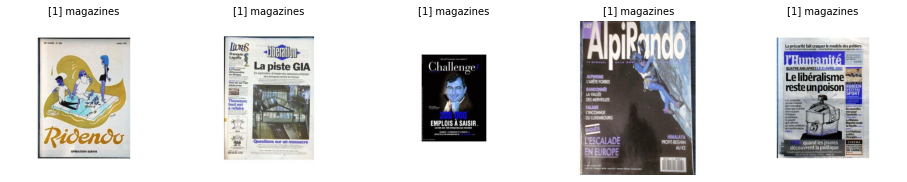

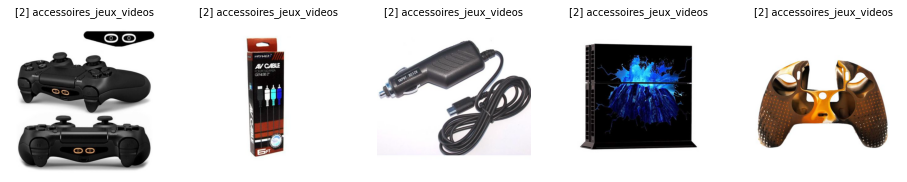

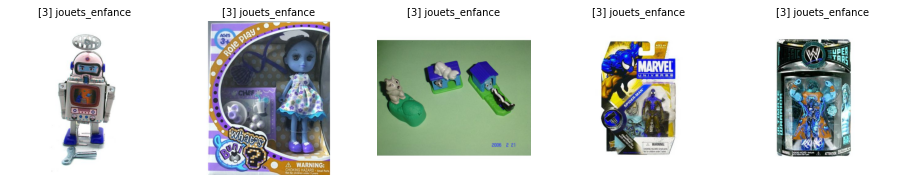

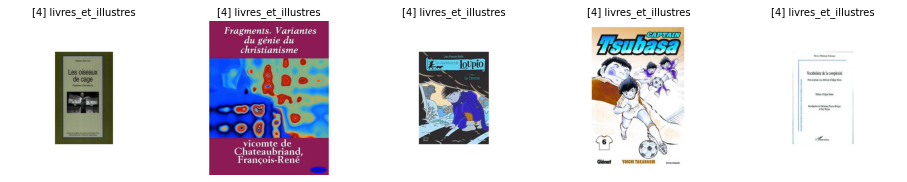

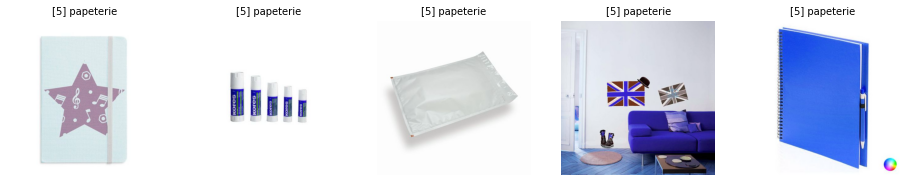

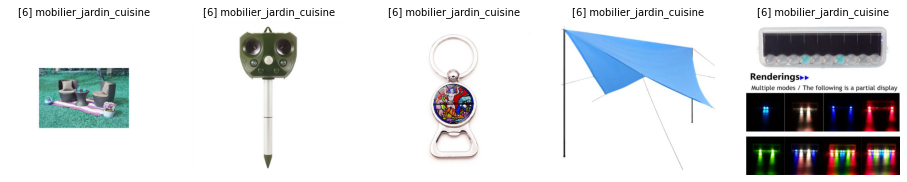

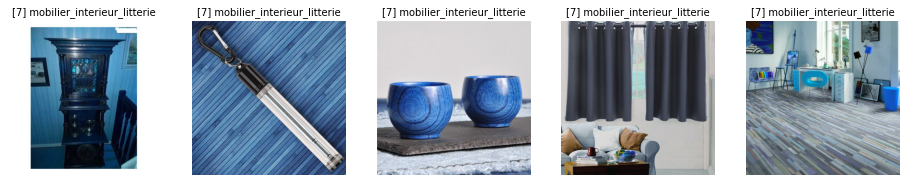

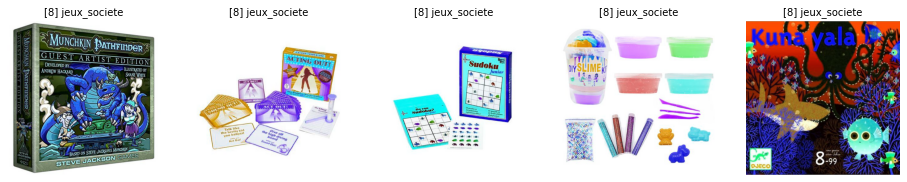

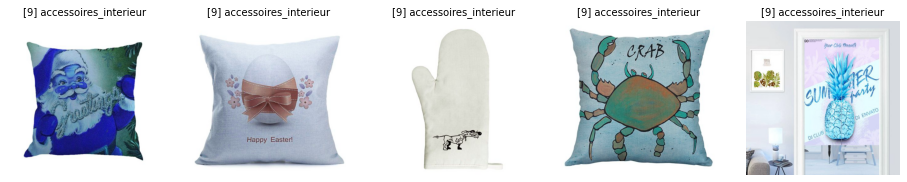

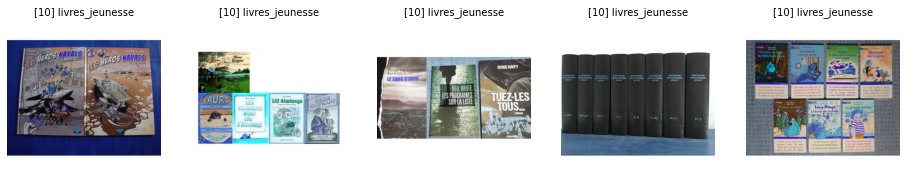

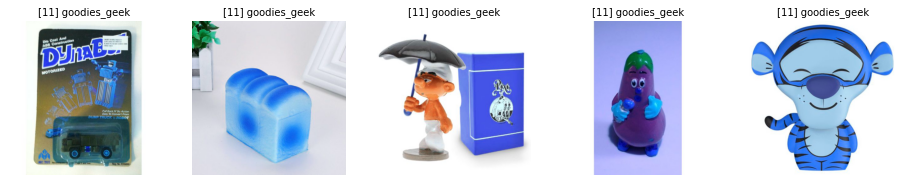

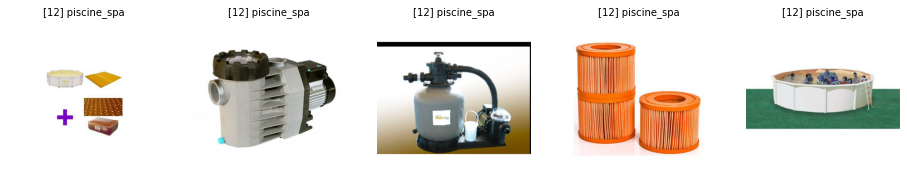

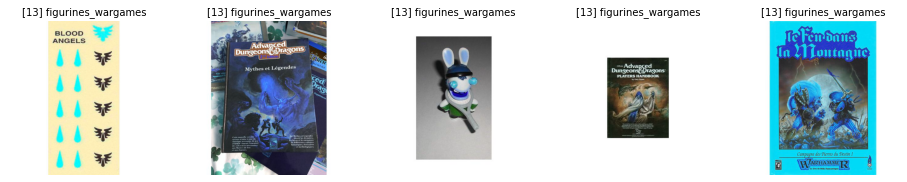

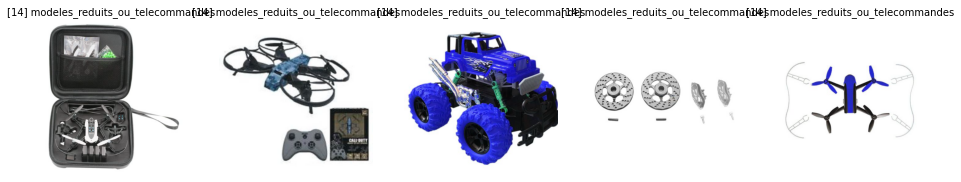

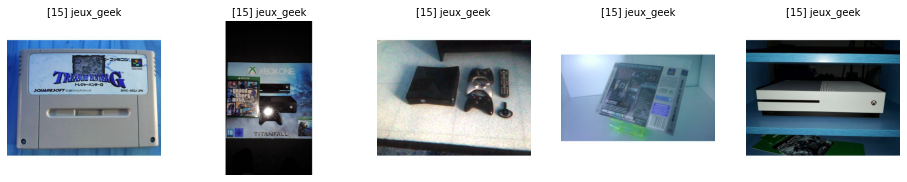

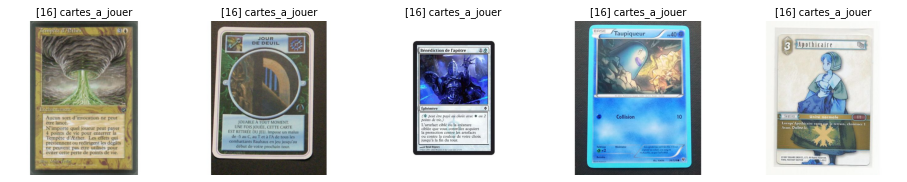

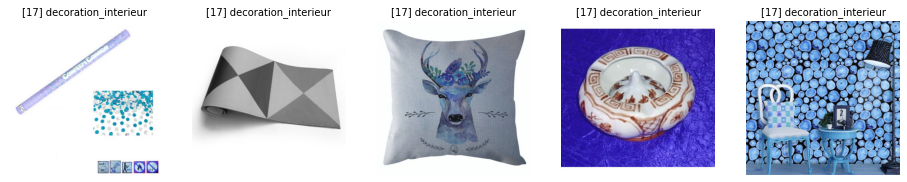

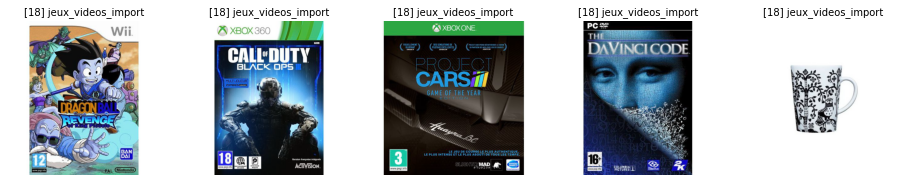

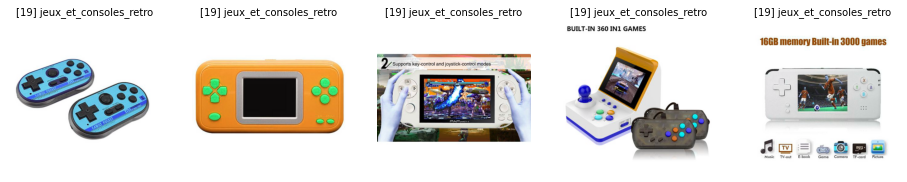

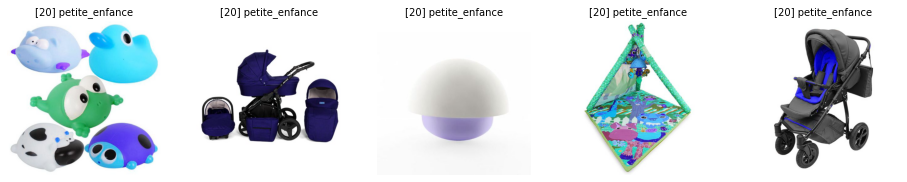

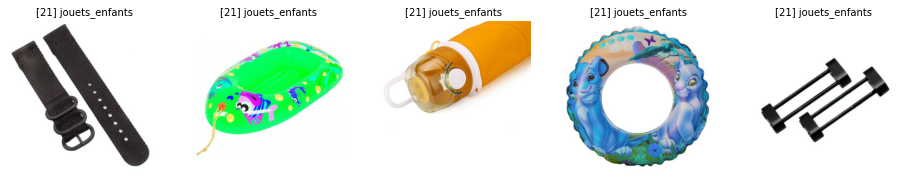

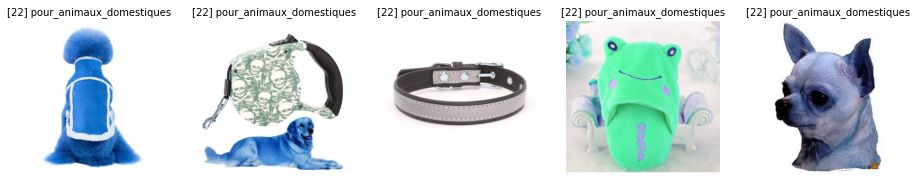

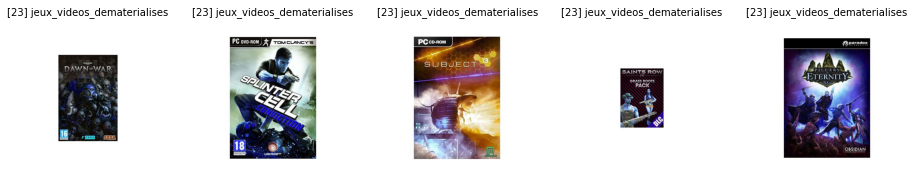

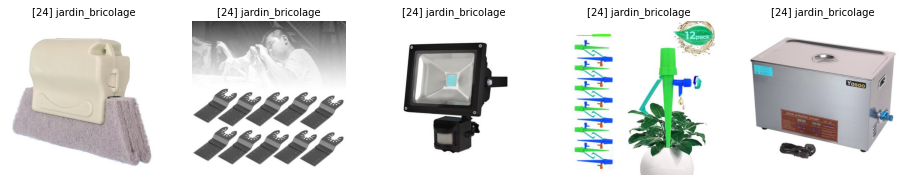

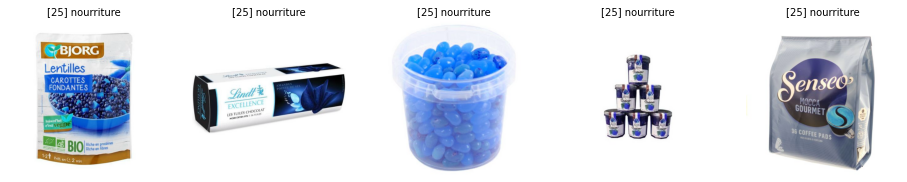

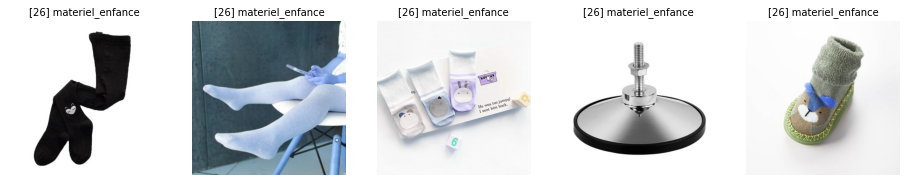

In [9]:
with plt.rc_context({'figure.max_open_warning': 0}):

    # Iterate through product codes
    for label in tqdm(lab_enc['target']):

        # Indexes matching label
        idxs = list(df[df['target'] == label].index)

        # Sample random specimens
        idxs_rand = random.sample(idxs, 5)
        
        # Extract imageids
        imageids = df.loc[idxs_rand, 'imageid']

        # Titres
        idx_lab = (lab_enc['target'] == label)
        titles = "[{}] ".format(list(lab_enc.loc[idx_lab, 'target'])[0])
        titles += list(lab_enc.loc[idx_lab, 'prdtype'])[0]
        titles = [titles]*5

        # Load and display images
        images = imt.load_id(PATH_TRAIN, imageids)
        imt.disp_grid(images, 1, 5, titles=titles)

On constate déjà que même au sein d'une même classe, les images représentent des objets très divers.

## Images moyennes par classe

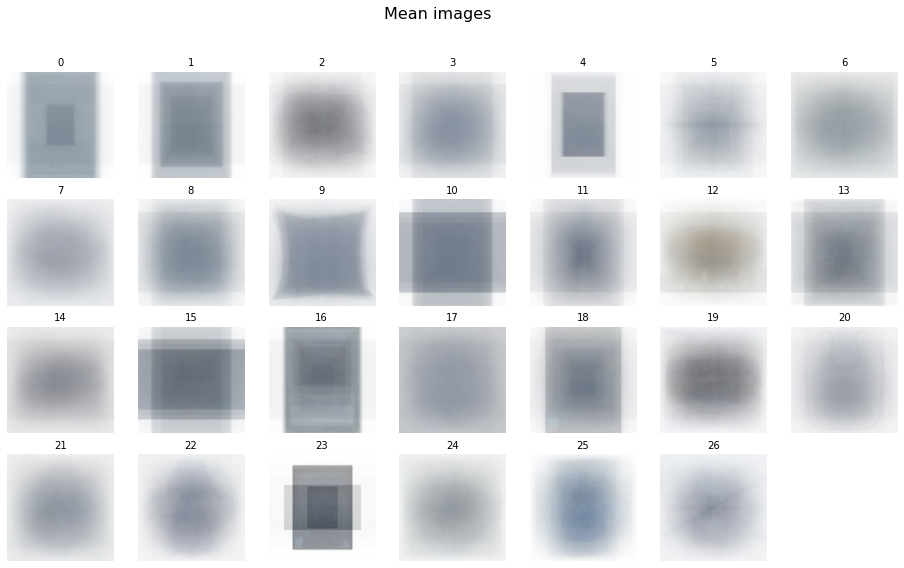

In [10]:
compute_mean_images = False # EDIT to run (or not) /!\ REALLY LONG computation /!\
save_result = False # EDIT to run (or not) /!\ Overwrites previous savefile if it exists /!\


SAVEFILE_NAME = 'mean_images_by_class.pkl'


if compute_mean_images:
    
    # Create empty container
    mean_images = dict()
    
    # Iterate through product codes
    for label in tqdm(lab_enc['target']):

        # Imageids matching label
        idxs = list(df[df['target'] == label].index)
        imageids = df.loc[idxs, 'imageid']
        
        # Load images
        images = imt.load_id(PATH_TRAIN, imageids)
        
        # Compute mean
        mean_images[label] = imt.mean_img(images)

        
if save_result:
    
    # Serialize in binary file
    with open(SAVEFILE_NAME, 'wb') as savefile:
        pickle.dump(mean_images, savefile)
    print("Results saved in '{}'.".format(SAVEFILE))



# Load and display
with open('mean_images_by_class.pkl', 'rb') as savefile:
    mean_images = pickle.load(savefile)
titles = list(lab_enc['target'])
imt.disp_grid(list(mean_images.values()), 4, 7, titles=titles, suptitle="Mean images")

Pour plusieurs classes, la dispersion de la luminance (les nuances de gris) est telle qu'on observe un genre de bruit gaussien 2D centré (classes 6, 7, 21, 24, ...). Pour quelques classes cependant, on observe des formes plus géométriques, surtout rectangulaires (classes 0, 1, 4, 10, 13, 15, 16, 23, ...). On pourrait imaginer que les objets concernés soit plutôt rectangulaires, et placés soit en portrait soit en paysage sur les images. Cependant, il faut être prudent, car toutes images ont été préformattées en RGB 500x500 pixels, et cela a pu créer un effet de cadre/bandeau sur les images.

Les couleurs observées, à dominante gris-brun, indiquent que la répartition entre les trois couleurs RGB est sensiblement la même (sauf par exemple pour la classe 25 un peu plus de bleu, ou la classe 19 un peu plus de rouge). La couleur observée au sein de chaque image semble relativement homogène, ce qui peut indiquer une forte dispersion pour chaque couleur primaire RGB (ce qui fait que le mélange des trois couleurs est à peu près le même partout).

Une telle dispersion nous oriente plutôt vers des méthodes de deep-learning.